In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
import pytorch_lightning as pl
import os
import torch
import torch.utils.data as data

In [ ]:
# pip3 install  "setuptools==59.5.0" "pytorch-lightning>=1.4" "matplotlib" "torch>=1.8" "ipython[notebook]" "torchmetrics>=0.7" "torchvision" "seaborn"

In [ ]:
!pip install pytorch_lightning

In [ ]:
DATASET_PATH = os.environ.get("PATH_DATASETS", "/content/data")

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(
            (32,32), scale=(0.8,1.0), ratio=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49,0.48,0.44],[0.24,0.24,0.26]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49,0.48,0.44],[0.24,0.24,0.26]),
    ]
)

In [ ]:
train_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=test_transform, download=True)
test_set = CIFAR10(
    root=DATASET_PATH, train=False, transform=test_transform, download=True)




pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000,5000])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:lightning_fabric.utilities.seed:Seed set to 42


In [ ]:
train_dataset = CIFAR10(
    root=DATASET_PATH, train=True, download=True)
test_set = CIFAR10(
    root=DATASET_PATH, train=False, transform=test_transform, download=True)


pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000,5000])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class TransformedDataset(data.Dataset):
  def __init__(self, subset, transform=None):
    self.subset = subset
    self.transform = transform

  def __getitem__(self, index):
    x, y = self.subset[index]
    if self.transform:
      x = self.transform(x)
    return x, y
  def __len__(self):
    return len(self.subset)

train_set_transformed = TransformedDataset(train_set, transform=train_transform)

In [ ]:
print(val_set)

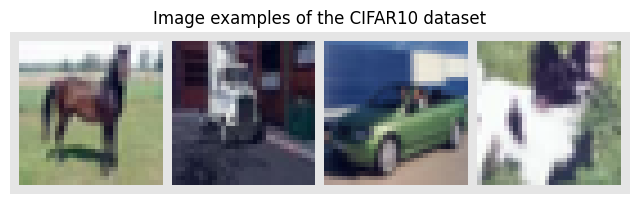

In [ ]:
import matplotlib.pyplot as plt
import torchvision

NUM_IMAGES = 4
CIFAR_images = torch.stack(
    [val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0
)

img_grid = torchvision.utils.make_grid(
    CIFAR_images, nrow=4, normalize= True, pad_value=0.9
)

img_grid = img_grid.permute(1,2,0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()



In [ ]:
train_loader = data.DataLoader(
    train_set, batch_size=128,
    shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(
    val_set, batch_size=128,
    shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(
    test_set, batch_size=128,
    shuffle=False, drop_last=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
#Tokenization

def img_to_patch(x, patch_size, flatten_channels=True):
  B, C, H, W = x.shape
  x = x.reshape(
      B,
      C,
      torch.div(H, patch_size, rounding_mode='trunc'),
      patch_size,
      torch.div(W, patch_size, rounding_mode='floor'),
      patch_size,
  )
  x = x.permute(0,2,4,1,3,5) #[B, H', W', C, p_H, p_W]
  x = x.flatten(1,2) #[B, H' * W', C, p_H, p_W]
  if flatten_channels:
    x = x.flatten(2,4) #[B, H' * W', C*p_H, p_W]
  return x

img_patches = img_to_patch(
    CIFAR_images, patch_size=4, flatten_channels=False
    )




In [ ]:
fig, ax = plt.subplots(CIFAR_images.shape[0],1,figsize=(14,3))
fig.suptitle("Images as input sequences of patches")

for i in range(CIFAR_images.shape[0]):
  img_grid = torchvision.utils.make_grid(
      img_patches[i], nrow = 64, normalize=True, pad_value = 0.9)
  img_grid = img_grid.permute(1,2,0)
  ax[i].imshow(img_grid)
  ax[i].axis("off")
plt.show()
plt.close()


In [ ]:
#Neural Net Module
import torch.nn as nn

class AttentionBlock(nn.Module):
  def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
    super().__init__()
    self.layer_norm_1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads)
    self.layer_norm_2 = nn.LayerNorm(embed_dim)
    self.linear = nn.Sequential(
        nn.Linear(embed_dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, embed_dim),
        nn.Dropout(dropout),
    )

  def forward(self, x):
    inp_x = self.layer_norm_1(x)
    x = x + self.attn(inp_x, inp_x, inp_x)[0]
    x = x + self.linear(self.layer_norm_2(x))
    return x



In [ ]:
class VisionTransformer(nn.Module):
  def __init__(
      self,
      embed_dim,
      hidden_dim,
      num_channels,
      num_heads,
      num_layers,
      num_classes,
      patch_size,
      num_patches,
      dropout= 0.0,
  ):
    super().__init__()
    self.patch_size = patch_size

    #Layers / Networks
    self.input_layer = nn.Linear(
        num_channels * (patch_size**2), embed_dim
    )
    self.transformer = nn.Sequential(
        *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout = dropout) for _ in range(num_layers))
    )
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim, num_classes)
    )
    self.dropout = nn.Dropout(dropout)

    #Parameters / Embeddings
    self.cls_token = nn.Parameter(
        torch.randn(1,1,embed_dim)
    )
    self.pos_embedd = nn.Parameter(
        torch.randn(1,1+num_patches, embed_dim)
    )

  def forward(self, x):
    x = img_to_patch(x,self.patch_size)
    B, T, _ = x.shape
    x = self.input_layer(x)

    cls_token = self.cls_token.repeat(B,1,1)
    x = torch.cat([cls_token,x],dim=1)
    x = x + self.pos_embedding[:,:T+1]

    x = self.dropout(x)
    x = x.transpose(0,1)
    x = self.transformer(x)

    cls = x[0]
    out = self.mlp_head(cls)
    return out


In [ ]:
import torch.nn.functional as F
import torch.optim as optim

class ViT(pl.LightningModule):
  def __init__(self, model_kwargs, lr):
    super().__init__()
    self.save_hyperparameters()
    self.model = VisionTransformer(**model_kwargs)

  def forward(self, x):
    return self.model(x)

  def configure_optimizers(self):
    optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
    lr_scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[100,150], gamma=0.1
    )
    return [optimizer],[lr_scheduler]

  def _calculate_loss(self, batch, mode="train"):
    imgs, labels = batch
    preds = self.model(imgs)
    loss = F.cross_entropy(preds, labels)
    acc = (preds.argmax(dim=-1)==labels).float().mean()

    self.log("%s_loss"%mode, loss, prog_bar=True)
    self.log("%s_acc"%mode, acc, prog_bar=True)
    return loss

  def training_step(self, batch, batch_idx):
    loss = self._calculate_loss(batch, mode="train")
    return loss
  def validation_steps(self, batch, batch_idx):
    self._calculate_loss(batch, mode="val")
  def test_step(self, batch, batch_idx):
    self._calculate_loss(batch, mode="test")


In [ ]:
CHECKPOINT_PATH = os.environ.get(
    "PATH_CHECKPOINT",
    "saved_models/VisionTransformers/"
)

def train_model(**kwards):
  trainer = pl.Trainer(
      default_root_dir = os.path.join(CHECKPOINT_PATH, "ViT"),
      fast_dev_run=5,
  )

  pl.seed_everything(42)
  model = ViT(**kwargs)
  trainer.fit(model, train_loader, val_loader)
  test_result = trainer.test(
      model, dataloaders = test_loader, verbose=False
  )
  return model, test_result


In [ ]:
model, results = train_model(
    model_kwargs={
        "embed_dim":256,
        "hidden_dim":512,
        "num_heads":8,
        "num_layers":6,
        "patch_size":4,
        "num_channels":3,
        "num_patches":64,
        "num_classes":10,
        "dropout":0.2,
    },
    lr=3e-4,
)
print("Results", results)